In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_DO_025_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=64, strides=1, padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=64*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.25))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO_025_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_10 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_10 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_11 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_11 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 5333, 64)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_28 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_28 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_29 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_29 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 5333, 64)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.0084 - acc: 0.2286
Epoch 00001: val_loss improved from inf to 2.30513, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_1_conv_checkpoint/001-2.3051.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 4.0082 - acc: 0.2286 - val_loss: 2.3051 - val_acc: 0.2982
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6122 - acc: 0.5351
Epoch 00002: val_loss did not improve from 2.30513
36805/36805 [==============================] - 43s 1ms/sample - loss: 1.6121 - acc: 0.5351 - val_loss: 2.6695 - val_acc: 0.3014
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0318 - acc: 0.6973
Epoch 00003: val_loss did not improve from 2.30513
36805/36805 [==============================] - 43s 1ms/sample - loss: 1.0316 - acc: 0.6973 - val_loss: 2.9495 -

36800/36805 [============================>.] - ETA: 0s - loss: 0.0693 - acc: 0.9893
Epoch 00029: val_loss did not improve from 2.30513
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.0693 - acc: 0.9893 - val_loss: 6.9553 - val_acc: 0.2874
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0654 - acc: 0.9907
Epoch 00030: val_loss did not improve from 2.30513
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.0654 - acc: 0.9907 - val_loss: 7.1699 - val_acc: 0.2788
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0709 - acc: 0.9890
Epoch 00031: val_loss did not improve from 2.30513
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.0709 - acc: 0.9890 - val_loss: 6.3579 - val_acc: 0.3040
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0678 - acc: 0.9893
Epoch 00032: val_loss did not improve from 2.30513
36805/36805 [========================

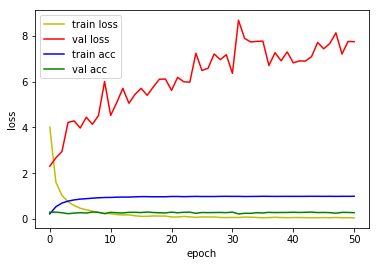

4815/4815 [==============================] - 2s 399us/sample - loss: 2.5974 - acc: 0.2079
Loss: 2.5973675454021863 Accuracy: 0.207892

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 5.5263 - acc: 0.2715
Epoch 00001: val_loss improved from inf to 6.17081, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_2_conv_checkpoint/001-6.1708.hdf5
36805/36805 [==============================] - 73s 2ms/sample - loss: 5.5265 - acc: 0.2715 - val_loss: 6.1708 - val_acc: 0.2055
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.8107 - acc: 0.4187
Epoch 00002: val_loss improved from 6.17081 to 5.60205, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_2_conv_checkpoint/002-5.6021.hdf5
36805/36805 [==============================] - 71s 2ms/sample - loss: 4.8105 - acc: 0.4188 - val_loss: 5.6021 - val_acc: 0.2940
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - los

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.7183 - acc: 0.7537
Epoch 00029: val_loss did not improve from 5.07886
36805/36805 [==============================] - 71s 2ms/sample - loss: 3.7182 - acc: 0.7537 - val_loss: 7.4217 - val_acc: 0.3529
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.6972 - acc: 0.7592
Epoch 00030: val_loss did not improve from 5.07886
36805/36805 [==============================] - 71s 2ms/sample - loss: 3.6976 - acc: 0.7592 - val_loss: 6.6948 - val_acc: 0.3993
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.7019 - acc: 0.7564
Epoch 00031: val_loss did not improve from 5.07886
36805/36805 [==============================] - 71s 2ms/sample - loss: 3.7014 - acc: 0.7564 - val_loss: 8.0441 - val_acc: 0.3175
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.7077 - acc: 0.7565
Epoch 00032: val_loss did not improve from 5.07886
36805/36805 [===========

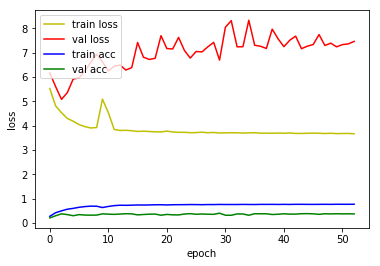

4815/4815 [==============================] - 3s 692us/sample - loss: 5.5207 - acc: 0.3109
Loss: 5.520678541296368 Accuracy: 0.31090343

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1803 - acc: 0.3683
Epoch 00001: val_loss improved from inf to 2.05167, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_3_conv_checkpoint/001-2.0517.hdf5
36805/36805 [==============================] - 84s 2ms/sample - loss: 2.1803 - acc: 0.3683 - val_loss: 2.0517 - val_acc: 0.3503
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4174 - acc: 0.5664
Epoch 00002: val_loss improved from 2.05167 to 1.69316, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_3_conv_checkpoint/002-1.6932.hdf5
36805/36805 [==============================] - 81s 2ms/sample - loss: 1.4173 - acc: 0.5664 - val_loss: 1.6932 - val_acc: 0.5101
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0655 - acc: 0.9824
Epoch 00029: val_loss did not improve from 1.62950
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.0655 - acc: 0.9824 - val_loss: 2.6213 - val_acc: 0.5856
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0767 - acc: 0.9793
Epoch 00030: val_loss did not improve from 1.62950
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0772 - acc: 0.9792 - val_loss: 3.4868 - val_acc: 0.5220
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0823 - acc: 0.9785
Epoch 00031: val_loss did not improve from 1.62950
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.0824 - acc: 0.9785 - val_loss: 2.5379 - val_acc: 0.5966
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0552 - acc: 0.9863
Epoch 00032: val_loss did not improve from 1.62950
36805/36805 [===========

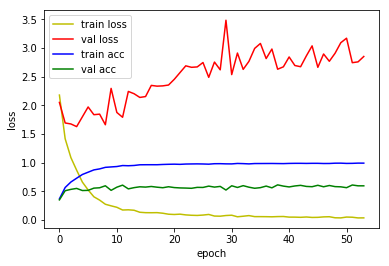

4815/4815 [==============================] - 4s 802us/sample - loss: 1.7122 - acc: 0.5300
Loss: 1.712230934457987 Accuracy: 0.5300104

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8930 - acc: 0.4116
Epoch 00001: val_loss improved from inf to 1.62700, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_4_conv_checkpoint/001-1.6270.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 1.8928 - acc: 0.4117 - val_loss: 1.6270 - val_acc: 0.4605
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2413 - acc: 0.6084
Epoch 00002: val_loss improved from 1.62700 to 1.25135, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_4_conv_checkpoint/002-1.2513.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 1.2412 - acc: 0.6084 - val_loss: 1.2513 - val_acc: 0.6077
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - los

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0876 - acc: 0.9755
Epoch 00029: val_loss did not improve from 0.98514
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.0876 - acc: 0.9755 - val_loss: 1.3969 - val_acc: 0.7056
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0823 - acc: 0.9761
Epoch 00030: val_loss did not improve from 0.98514
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.0823 - acc: 0.9761 - val_loss: 1.3366 - val_acc: 0.7147
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0866 - acc: 0.9750
Epoch 00031: val_loss did not improve from 0.98514
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.0866 - acc: 0.9750 - val_loss: 1.2987 - val_acc: 0.7160
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0915 - acc: 0.9735
Epoch 00032: val_loss did not improve from 0.98514
36805/36805 [===========

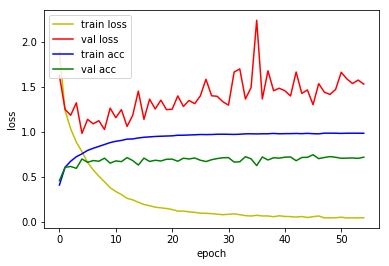

4815/4815 [==============================] - 4s 848us/sample - loss: 1.0929 - acc: 0.6822
Loss: 1.0929453831471634 Accuracy: 0.682243

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8228 - acc: 0.4374
Epoch 00001: val_loss improved from inf to 1.49650, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_5_conv_checkpoint/001-1.4965.hdf5
36805/36805 [==============================] - 94s 3ms/sample - loss: 1.8227 - acc: 0.4375 - val_loss: 1.4965 - val_acc: 0.4978
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1734 - acc: 0.6377
Epoch 00002: val_loss improved from 1.49650 to 1.07757, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_5_conv_checkpoint/002-1.0776.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 1.1734 - acc: 0.6377 - val_loss: 1.0776 - val_acc: 0.6674
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - los

36800/36805 [============================>.] - ETA: 0s - loss: 0.1217 - acc: 0.9651
Epoch 00027: val_loss did not improve from 0.72161
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1217 - acc: 0.9650 - val_loss: 1.0063 - val_acc: 0.7612
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1188 - acc: 0.9648
Epoch 00028: val_loss did not improve from 0.72161
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1189 - acc: 0.9647 - val_loss: 0.8565 - val_acc: 0.7943
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1118 - acc: 0.9671
Epoch 00029: val_loss did not improve from 0.72161
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1119 - acc: 0.9670 - val_loss: 0.8422 - val_acc: 0.8060
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1135 - acc: 0.9677
Epoch 00030: val_loss did not improve from 0.72161
36805/36805 [========================

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0522 - acc: 0.9855
Epoch 00057: val_loss did not improve from 0.72161
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0523 - acc: 0.9855 - val_loss: 1.0939 - val_acc: 0.7887
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0531 - acc: 0.9853
Epoch 00058: val_loss did not improve from 0.72161
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0532 - acc: 0.9852 - val_loss: 0.9593 - val_acc: 0.8008
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0499 - acc: 0.9863
Epoch 00059: val_loss did not improve from 0.72161
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0499 - acc: 0.9863 - val_loss: 0.9554 - val_acc: 0.8085
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0449 - acc: 0.9881
Epoch 00060: val_loss did not improve from 0.72161
36805/36805 [===========

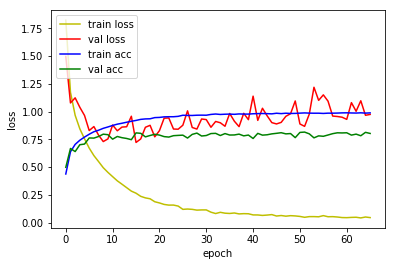

4815/4815 [==============================] - 4s 894us/sample - loss: 0.8210 - acc: 0.7751
Loss: 0.8210204897392328 Accuracy: 0.7750779

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8155 - acc: 0.4260
Epoch 00001: val_loss improved from inf to 1.39722, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_6_conv_checkpoint/001-1.3972.hdf5
36805/36805 [==============================] - 98s 3ms/sample - loss: 1.8153 - acc: 0.4261 - val_loss: 1.3972 - val_acc: 0.5381
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1354 - acc: 0.6439
Epoch 00002: val_loss improved from 1.39722 to 0.94022, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_6_conv_checkpoint/002-0.9402.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 1.1356 - acc: 0.6438 - val_loss: 0.9402 - val_acc: 0.7128
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - lo

36800/36805 [============================>.] - ETA: 0s - loss: 0.1694 - acc: 0.9488
Epoch 00025: val_loss did not improve from 0.44987
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1695 - acc: 0.9487 - val_loss: 0.6127 - val_acc: 0.8526
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1650 - acc: 0.9497
Epoch 00026: val_loss improved from 0.44987 to 0.44142, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_6_conv_checkpoint/026-0.4414.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1650 - acc: 0.9497 - val_loss: 0.4414 - val_acc: 0.8796
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1549 - acc: 0.9538
Epoch 00027: val_loss did not improve from 0.44142
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1550 - acc: 0.9537 - val_loss: 0.4617 - val_acc: 0.8777
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1448 - a

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0600 - acc: 0.9837
Epoch 00055: val_loss did not improve from 0.44142
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0599 - acc: 0.9837 - val_loss: 0.5058 - val_acc: 0.8849
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0540 - acc: 0.9853
Epoch 00056: val_loss did not improve from 0.44142
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0540 - acc: 0.9852 - val_loss: 0.6215 - val_acc: 0.8560
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0571 - acc: 0.9839
Epoch 00057: val_loss did not improve from 0.44142
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0573 - acc: 0.9838 - val_loss: 0.6122 - val_acc: 0.8735
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0641 - acc: 0.9813
Epoch 00058: val_loss did not improve from 0.44142
36805/36805 [===========

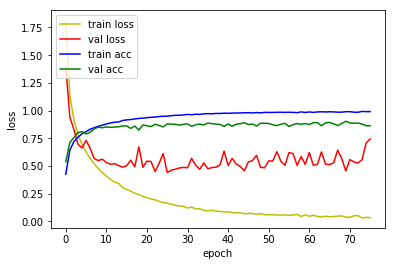

4815/4815 [==============================] - 4s 925us/sample - loss: 0.5072 - acc: 0.8673
Loss: 0.507212621976282 Accuracy: 0.8672897

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9473 - acc: 0.3926
Epoch 00001: val_loss improved from inf to 1.39423, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_7_conv_checkpoint/001-1.3942.hdf5
36805/36805 [==============================] - 102s 3ms/sample - loss: 1.9472 - acc: 0.3927 - val_loss: 1.3942 - val_acc: 0.5535
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1008 - acc: 0.6545
Epoch 00002: val_loss improved from 1.39423 to 1.01116, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_7_conv_checkpoint/002-1.0112.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 1.1007 - acc: 0.6545 - val_loss: 1.0112 - val_acc: 0.6886
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1095 - acc: 0.9672
Epoch 00026: val_loss improved from 0.25478 to 0.24528, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_7_conv_checkpoint/026-0.2453.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1094 - acc: 0.9672 - val_loss: 0.2453 - val_acc: 0.9315
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1049 - acc: 0.9684
Epoch 00027: val_loss did not improve from 0.24528
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1049 - acc: 0.9684 - val_loss: 0.3853 - val_acc: 0.8938
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1008 - acc: 0.9709
Epoch 00028: val_loss did not improve from 0.24528
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1008 - acc: 0.9709 - val_loss: 0.2698 - val_acc: 0.9259
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - los

36800/36805 [============================>.] - ETA: 0s - loss: 0.0311 - acc: 0.9920
Epoch 00054: val_loss did not improve from 0.22482
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0314 - acc: 0.9920 - val_loss: 0.3621 - val_acc: 0.9210
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0423 - acc: 0.9882
Epoch 00055: val_loss did not improve from 0.22482
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0423 - acc: 0.9882 - val_loss: 0.2727 - val_acc: 0.9376
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0342 - acc: 0.9906
Epoch 00056: val_loss did not improve from 0.22482
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0342 - acc: 0.9906 - val_loss: 0.3798 - val_acc: 0.9115
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0344 - acc: 0.9903
Epoch 00057: val_loss did not improve from 0.22482
36805/36805 [========================

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0240 - acc: 0.9930
Epoch 00084: val_loss did not improve from 0.22482
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0240 - acc: 0.9930 - val_loss: 0.3127 - val_acc: 0.9334
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0148 - acc: 0.9961
Epoch 00085: val_loss did not improve from 0.22482
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0148 - acc: 0.9961 - val_loss: 0.2635 - val_acc: 0.9457
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0173 - acc: 0.9956
Epoch 00086: val_loss did not improve from 0.22482
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0173 - acc: 0.9956 - val_loss: 0.2584 - val_acc: 0.9460
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0185 - acc: 0.9948
Epoch 00087: val_loss did not improve from 0.22482
36805/36805 [===========

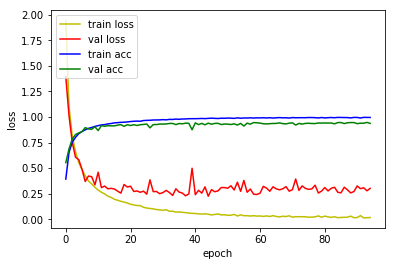

4815/4815 [==============================] - 5s 997us/sample - loss: 0.2547 - acc: 0.9310
Loss: 0.2547494203548565 Accuracy: 0.9310488

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8075 - acc: 0.4369
Epoch 00001: val_loss improved from inf to 1.30572, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_8_conv_checkpoint/001-1.3057.hdf5
36805/36805 [==============================] - 106s 3ms/sample - loss: 1.8074 - acc: 0.4369 - val_loss: 1.3057 - val_acc: 0.6063
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8977 - acc: 0.7259
Epoch 00002: val_loss improved from 1.30572 to 0.56625, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_8_conv_checkpoint/002-0.5662.hdf5
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.8978 - acc: 0.7258 - val_loss: 0.5662 - val_acc: 0.8404
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - l

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0564 - acc: 0.9837
Epoch 00026: val_loss did not improve from 0.15847
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0564 - acc: 0.9837 - val_loss: 0.1979 - val_acc: 0.9446
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0557 - acc: 0.9834
Epoch 00027: val_loss did not improve from 0.15847
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0557 - acc: 0.9834 - val_loss: 0.1756 - val_acc: 0.9548
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0508 - acc: 0.9858
Epoch 00028: val_loss did not improve from 0.15847
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0508 - acc: 0.9858 - val_loss: 0.1631 - val_acc: 0.9525
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0483 - acc: 0.9857
Epoch 00029: val_loss did not improve from 0.15847
36805/36805 [===========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0165 - acc: 0.9958
Epoch 00055: val_loss did not improve from 0.15140
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0165 - acc: 0.9958 - val_loss: 0.2473 - val_acc: 0.9469
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0207 - acc: 0.9940
Epoch 00056: val_loss did not improve from 0.15140
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0207 - acc: 0.9940 - val_loss: 0.1655 - val_acc: 0.9616
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0147 - acc: 0.9960
Epoch 00057: val_loss did not improve from 0.15140
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0148 - acc: 0.9960 - val_loss: 0.2196 - val_acc: 0.9539
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0175 - acc: 0.9951
Epoch 00058: val_loss did not improve from 0.15140
36805/36805 [===========

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0175 - acc: 0.9950
Epoch 00085: val_loss did not improve from 0.15140
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0175 - acc: 0.9950 - val_loss: 0.1674 - val_acc: 0.9585
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0097 - acc: 0.9974
Epoch 00086: val_loss did not improve from 0.15140
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0097 - acc: 0.9974 - val_loss: 0.1987 - val_acc: 0.9569
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0076 - acc: 0.9979
Epoch 00087: val_loss did not improve from 0.15140
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0078 - acc: 0.9979 - val_loss: 0.1807 - val_acc: 0.9623
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0209 - acc: 0.9940
Epoch 00088: val_loss did not improve from 0.15140
36805/36805 [===========

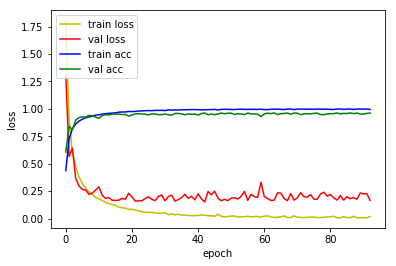

4815/4815 [==============================] - 5s 999us/sample - loss: 0.1810 - acc: 0.9504
Loss: 0.18099794007319403 Accuracy: 0.95036346

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3882 - acc: 0.5689
Epoch 00001: val_loss improved from inf to 0.91194, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_9_conv_checkpoint/001-0.9119.hdf5
36805/36805 [==============================] - 110s 3ms/sample - loss: 1.3882 - acc: 0.5689 - val_loss: 0.9119 - val_acc: 0.7270
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5477 - acc: 0.8307
Epoch 00002: val_loss improved from 0.91194 to 0.37540, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_9_conv_checkpoint/002-0.3754.hdf5
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.5478 - acc: 0.8306 - val_loss: 0.3754 - val_acc: 0.8891
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0239 - acc: 0.9937
Epoch 00027: val_loss did not improve from 0.13636
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0239 - acc: 0.9937 - val_loss: 0.1606 - val_acc: 0.9567
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0206 - acc: 0.9948
Epoch 00028: val_loss did not improve from 0.13636
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0206 - acc: 0.9948 - val_loss: 0.1622 - val_acc: 0.9571
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0226 - acc: 0.9938
Epoch 00029: val_loss did not improve from 0.13636
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0226 - acc: 0.9938 - val_loss: 0.1716 - val_acc: 0.9548
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0262 - acc: 0.9922
Epoch 00030: val_loss did not improve from 0.13636
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0084 - acc: 0.9975
Epoch 00057: val_loss did not improve from 0.13636
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0084 - acc: 0.9975 - val_loss: 0.1876 - val_acc: 0.9581
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0126 - acc: 0.9962
Epoch 00058: val_loss did not improve from 0.13636
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0126 - acc: 0.9962 - val_loss: 0.2009 - val_acc: 0.9576
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0101 - acc: 0.9970
Epoch 00059: val_loss did not improve from 0.13636
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0101 - acc: 0.9970 - val_loss: 0.1646 - val_acc: 0.9630
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0103 - acc: 0.9968
Epoch 00060: val_loss did not improve from 0.13636
36805/36805 [===========

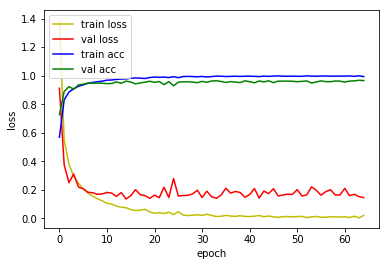

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1722 - acc: 0.9479
Loss: 0.1721713190695207 Accuracy: 0.9478712



In [10]:
for i in range(1, 10):
    base = '1D_CNN_custom_DO_025_DO_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO_025_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_DO_025_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_DO_025_DO_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,384,656
Trainable params: 16,384,528
Non-trainable params: 128
_____________________

4815/4815 [==============================] - 5s 1ms/sample - loss: 1.0929 - acc: 0.6822
Loss: 1.0929453831471634 Accuracy: 0.682243

1D_CNN_custom_DO_025_DO_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_55 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_55 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_55 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_56 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_56 (Activation)   (None,

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2547 - acc: 0.9310
Loss: 0.2547494203548565 Accuracy: 0.9310488

1D_CNN_custom_DO_025_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_73 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_73 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_74 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_74 (Activation)   (None

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1722 - acc: 0.9479
Loss: 0.1721713190695207 Accuracy: 0.9478712
